# **03 - Correlation Analysis and Visualization**

## Objectives
* Analyze relationships between house attributes and the target variable `SalePrice` to identify key predictors for modeling.
* Validate hypotheses by performing correlation analysis and visualizing the results.
* Identify both linear and non-linear relationships using correlation and predictive power score (PPS) analysis.
* Generate insights through visualizations such as heatmaps, scatterplots, and boxplots to demonstrate the strength and direction of relationships.
* Identify the most relevant variables for regression modeling.
* Save visualizations for use in the Streamlit app and to communicate findings effectively.


## Inputs
* Cleaned dataset: `outputs/datasets/cleaned/house_prices_cleaned.parquet`.
* Hypotheses documented in the project [README.md](#) file.


## Outputs
* Reusable code that answers **Business Requirement 1** by analyzing correlations and creating visualizations.
    * The code will also be used in the Streamlit app.
* Data plots saved in the `docs/plots` directory for use in the Streamlit app.
* A list of the most relevant variables for the regression model based on the correlation analysis.


## Additional Comments
* The visualizations in this notebook will be used in the final dashboard to meet **Business Requirement 1**.
* They also serve as a tool to validate hypotheses and communicate insights effectively.

---

## Change Working Directory

Ensure the working directory is set to the project root for consistent file paths. This ensures that all file paths work correctly, regardless of where the notebook is executed.

In [225]:
import os
current_dir = os.getcwd()
current_dir

'd:\\Projects\\milestone-project-heritage-housing-issues'

In [226]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [227]:
current_dir = os.getcwd()
current_dir

'd:\\Projects'

---

## 1. Load Data

In [229]:
# Import Pandas for data manipulation
import pandas as pd

# Create DataFrame containing cleaned house price dataset
df = pd.read_parquet("outputs/datasets/cleaned/house_prices_cleaned.parquet")

# Display DataFrames first five rows
df.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,0.0,3.0,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,0.0,4.0,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


---

## 2. Data Exploration

### 2.1 Generate Profiling Report
Generate a detailed  report for exploratory data analysis.

In [230]:
# Import YData Profiling library
from ydata_profiling import ProfileReport

# Generate profile report
profile_report = ProfileReport(df=df, minimal=True)

# Display the profile report in notebook
profile_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 22/22 [00:00<?, ?it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

## 3. Correlation and PPS Analysis

### 3.1 Convert Categorical Variables
Categorical variables stored as `object` converts into numerical format to incorporate them in the correlation analysis.

In [231]:
# Import feature engineering library for encoding categorical variables
from feature_engine.encoding import OneHotEncoder

# Initialize OneHotEncoder and create a list of categorical variables
encoder = OneHotEncoder(variables=df.columns[df.dtypes=='object'].to_list(), drop_last=False)

# Fit and transform the data
df_ohe = encoder.fit_transform(df)

# Display the number of rows/columns and first five rows of the transformed DataFrame
print(df_ohe.shape)
df_ohe.head(5)

(1460, 36)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtUnfSF,GarageArea,GarageYrBlt,GrLivArea,LotArea,LotFrontage,...,BsmtFinType1_BLQ,BsmtFinType1_LwQ,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_None,GarageFinish_Fin,KitchenQual_Gd,KitchenQual_TA,KitchenQual_Ex,KitchenQual_Fa
0,856,854.0,3.0,706,150,548,2003.0,1710,8450,65.0,...,0,0,1,0,0,0,1,0,0,0
1,1262,0.0,3.0,978,284,460,1976.0,1262,9600,80.0,...,0,0,1,0,0,0,0,1,0,0
2,920,866.0,3.0,486,434,608,2001.0,1786,11250,68.0,...,0,0,1,0,0,0,1,0,0,0
3,961,0.0,3.0,216,540,642,1998.0,1717,9550,60.0,...,0,0,0,1,0,0,1,0,0,0
4,1145,0.0,4.0,655,490,836,2000.0,2198,14260,84.0,...,0,0,1,0,0,0,1,0,0,0


### 3.2 Calculate and Visualize Relationships in Dataset

We define a set of functions to calculate and visualize the relationships between variables in the dataset. These functions generate heatmaps for correlation (Pearson and Spearman) and predictive power (PPS), offering insights into both linear, monotonic, and non-linear relationships. To maintain a clean and focused output, we suppress `FutureWarning` messages, which are not critical to the analysis but may clutter the console. The code ensures that the `docs/plots` directory exists, creating it if necessary, so that all generated plots are saved in an organized manner for easy access and future use. For clarity, heatmaps hide values that are 0 or less than 0.2, providing a cleaner and more interpretable visualization.

In [232]:
# Import 
import os

# Import visualization libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import predictive power score library
import ppscore as pps

# Import warnings
import warnings

# Enable inline plotting
%matplotlib inline

# Ignore FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set theme
sns.set_theme(style="darkgrid")

# Check and create the folder to save plots
def ensure_directory_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created.")


def correlation_heatmap(df, threshold=0.5, figsize=(12, 8), font_size=8, title="Correlation Heatmap", save_path=None):
    """
    Generate a heatmap to visualize strong correlations between variables.
    This helps identify key predictors for the target variable `SalePrice` and understand relationships in the dataset.
    """
    if df.shape[1] > 1:  # Check for enough columns
        # Filter rows and columns with values below the threshold
        filtered_data = df.loc[(abs(df) >= threshold).any(axis=1), (abs(df) >= threshold).any(axis=0)]

        # Create a mask to hide the upper triangle and values that are 0
        mask = np.zeros_like(filtered_data, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[(abs(filtered_data) <= 0.2)] = True

        # Format data for better readability
        formatted_data = filtered_data.applymap(lambda x: round(x, 2) if abs(x) > 0.2 else 0)

        # Draw heatmap
        plt.figure(figsize=figsize)
        sns.heatmap(
            formatted_data, 
            annot=True, 
            cmap=sns.color_palette("Spectral"),
            mask=mask, 
            annot_kws={"size": font_size}, 
            linewidths=0.5
        )
        plt.title(title)

        # Save heatmap and show plot
        if save_path:
            ensure_directory_exists(os.path.dirname(save_path))  # Ensure directory exists
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Heatmap saved to {save_path}")   
        plt.show()

# Generate a heatmap for PPS matrices, filtering out weak predictive scores.
def pps_heatmap(df, threshold=0.2, figsize=(12, 8), font_size=8, title="PPS Heatmap", save_path=None):
    if df.shape[1] > 1:

        # Filter rows and columns with values under the threshold
        filtered_data = df.loc[(abs(df) >= threshold).any(axis=1), (abs(df) >= threshold).any(axis=0)]

        # Create a mask to hide values <= 0.2 and values that are exactly 0
        mask = np.zeros_like(filtered_data, dtype=bool)
        mask[abs(filtered_data) <= 0.2] = True 
        mask[filtered_data == 0] = True

        # Format data for better readability
        formatted_data = filtered_data.applymap(lambda x: round(x, 2) if abs(x) > 0.2 else 0)

        # Draw heatmap
        plt.figure(figsize=figsize)
        ax = sns.heatmap(
            formatted_data, 
            annot=True, 
            cmap=sns.color_palette("Spectral"),
            annot_kws={"size": font_size}, 
            linewidths=0.5,
            mask=mask
        )
        # Remove axis titles
        ax.set_xlabel('')
        ax.set_ylabel('')

        plt.title(title)

        # Save heatmap and show plot
        if save_path:
            ensure_directory_exists(os.path.dirname(save_path))  # Ensure directory exists
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Heatmap saved to {save_path}")
        plt.show()

d:\Projects\milestone-project-heritage-housing-issues\.venv\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


### 3.3 Correlation Analysis

In [233]:
# Select numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Compute Spearman correlation matrices
spearman_corr = numeric_df.corr(method="spearman")

# Compute Pearson correlation matrices
pearson_corr = numeric_df.corr(method="pearson")

### 3.4 Generate Correlation Heatmaps

#### 3.4.1 Spearman Correlation Heatmap
The Spearman method is used to evaluate monotonic relationships between variables. This heatmap highlights:
- Variables with strong monotonic relationships to the target variable `SalePrice`.
- Potential predictors for the regression model.

### Results
The heatmap shows that variables like `OverallQual`, `GrLivArea`, and `GarageArea` have strong monotonic relationships with `SalePrice`, making them key predictors for modeling.

Heatmap saved to docs/plots/spearman_correlation_heatmap.png


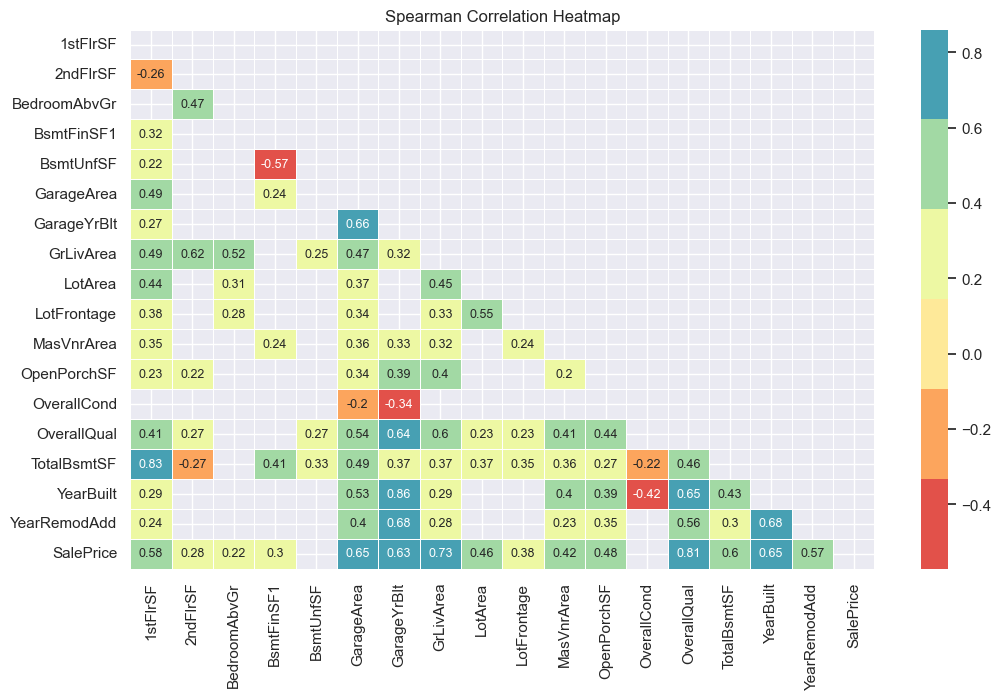

In [234]:
# Generate Spearman correlation heatmap
correlation_heatmap(
    df=spearman_corr,
    threshold=0.5,
    figsize=(12, 7),
    font_size=9,
    title="Spearman Correlation Heatmap",
    save_path="docs/plots/spearman_correlation_heatmap.png"
)

#### 3.4.2 Pearson Correlation Heatmap
Pearson method is used to evaluate linear relationships.

Heatmap saved to docs/plots/pearson_correlation_heatmap.png


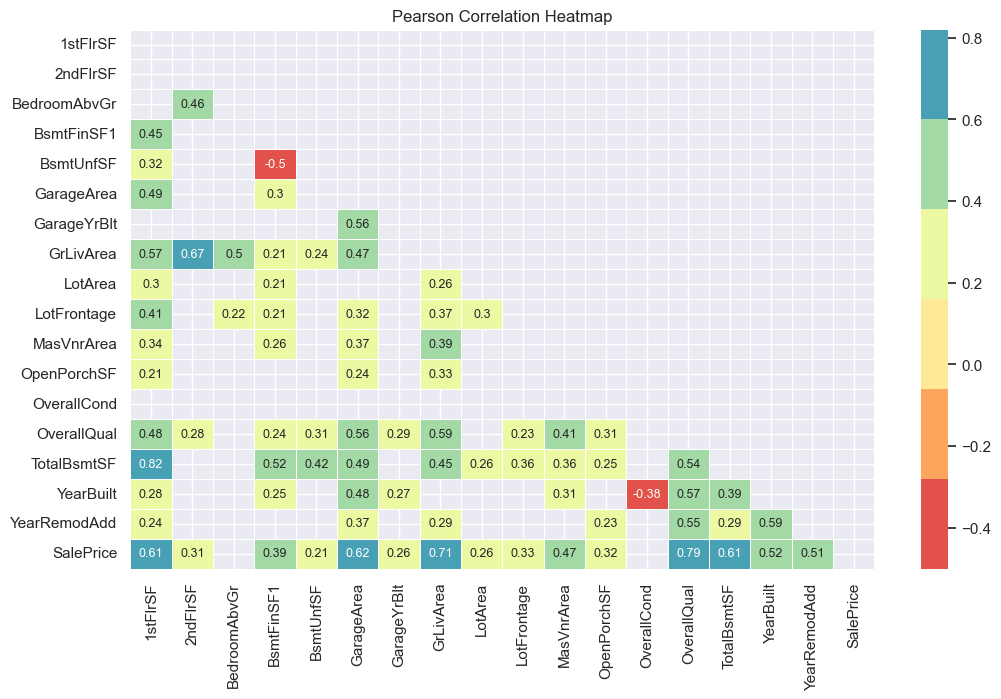

In [235]:
# Generate Pearson correlation heatmap
correlation_heatmap(
    df=pearson_corr,
    threshold=0.5,
    figsize=(12, 7),
    font_size=9,
    title="Pearson Correlation Heatmap",
    save_path="docs/plots/pearson_correlation_heatmap.png"
)

#### 3.4.3 Correlation Coenfficients
Using Spearman and Pearson correlation methods to find top 10 correlations attributes between target variable `SalePrice` and dataframe `df_ohe`.

In [236]:
# Spearman Top Correlation Features
spearman_corr = df_ohe.corr(method='spearman')['SalePrice'].sort_values(key=abs, ascending=False)[1:]
print("Top 10 Spearman correlations with SalePrice:")
spearman_corr.head(10)

# Pearson Top Correlation Features
pearson_corr = df_ohe.corr(method='pearson')['SalePrice'].sort_values(key=abs, ascending=False)[1:]
print("\nTop 10 Pearson correlations with SalePrice:")
print(pearson_corr.head(10))

# Combine the 10 best variables from Spearman and Pearson
top_n = 10
vars_to_study = set(
    pearson_corr.head(top_n).index.to_list() +
    spearman_corr.head(top_n).index.to_list()
)

# Add the target variable 'SalePrice'
selected_features = list(vars_to_study) + ['SalePrice']

# Create a new DataFrame with only the selected variables
df_filtered = df_ohe[selected_features]

# Display the first few rows of the new DataFrame
print("\nFiltered DataFrame with top variables:")
df_filtered.head()

Top 10 Spearman correlations with SalePrice:

Top 10 Pearson correlations with SalePrice:
OverallQual       0.790982
GrLivArea         0.708624
GarageArea        0.623431
TotalBsmtSF       0.613581
1stFlrSF          0.605852
YearBuilt         0.522897
KitchenQual_TA   -0.519298
YearRemodAdd      0.507101
KitchenQual_Ex    0.504094
MasVnrArea        0.472614
Name: SalePrice, dtype: float64

Filtered DataFrame with top variables:


,GarageYrBlt,MasVnrArea,OverallQual,TotalBsmtSF,GarageArea,KitchenQual_TA,KitchenQual_Ex,KitchenQual_Gd,YearBuilt,YearRemodAdd,1stFlrSF,GrLivArea,SalePrice
0,2003.0,196.0,7,856,548,0,0,1,2003,2003,856,1710,208500
1,1976.0,0.0,6,1262,460,1,0,0,1976,1976,1262,1262,181500
2,2001.0,162.0,7,920,608,0,0,1,2001,2002,920,1786,223500
3,1998.0,0.0,7,756,642,0,0,1,1915,1970,961,1717,140000
4,2000.0,350.0,8,1145,836,0,0,1,2000,2000,1145,2198,250000


### 3.6 Predictive Power Score (PPS) Matrix
PPS Matrix used to detect both linear and non-linear relationships.

In [237]:
# Compute predictive power scores
pps_matrix_raw = pps.matrix(df)

# Pivot the matrix
pps_matrix = pps_matrix_raw.pivot(index='y', columns='x', values='ppscore')

#### 3.6.1 Display PPS Matrix

In [238]:
# Compute descriptive statistics for PPS
pps_stats = pps_matrix_raw.query("ppscore < 1")['ppscore'].describe()

# Display the statistics
print("PPS Statistics:\n", pps_stats.round(3))

PPS Statistics:
 count    462.000
mean       0.056
std        0.106
min        0.000
25%        0.000
50%        0.000
75%        0.066
max        0.891
Name: ppscore, dtype: float64


#### 3.6.2 Generate Heatmap for PPS Matrix

Heatmap saved to docs/plots/pps_heatmap.png


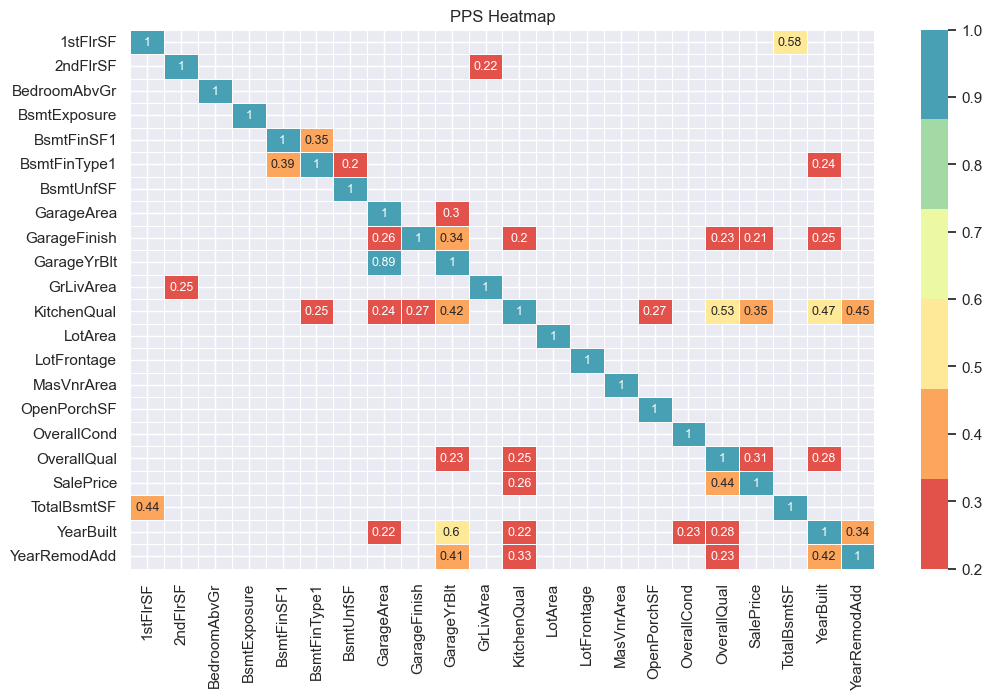

In [239]:
# Generate PPS heatmap
pps_heatmap(
    df=pps_matrix,
    threshold=0.2,
    figsize=(12, 7),
    font_size=9,
    title="PPS Heatmap",
    save_path="docs/plots/pps_heatmap.png"
)

---

## 4. Exploratory Data Analysis (EDA) on selected variables.

#### 4.1 Create New DataFrame for Exploratory Data Analysis

In [240]:
# Create list of top 10 variables and target variable
selected_features = list(vars_to_study) + ['SalePrice']

# Create DataFrame for EDA
df_eda = df_ohe[selected_features]

# Display the first five rows of the new DataFrame
df_eda.head(5)

,GarageYrBlt,MasVnrArea,OverallQual,TotalBsmtSF,GarageArea,KitchenQual_TA,KitchenQual_Ex,KitchenQual_Gd,YearBuilt,YearRemodAdd,1stFlrSF,GrLivArea,SalePrice
0,2003.0,196.0,7,856,548,0,0,1,2003,2003,856,1710,208500
1,1976.0,0.0,6,1262,460,1,0,0,1976,1976,1262,1262,181500
2,2001.0,162.0,7,920,608,0,0,1,2001,2002,920,1786,223500
3,1998.0,0.0,7,756,642,0,0,1,1915,1970,961,1717,140000
4,2000.0,350.0,8,1145,836,0,0,1,2000,2000,1145,2198,250000


### 4.2 Visualization of Target Variable Distrubition

We need to understand the distribution of the target variable (`SalePrice`) and identify whether it is skewed or contains outliers. This is important because skewness or outliers can affect the performance of predictive models.

We create a histogram with a KDE (Kernel Density Estimate) overlay to visualize the distribution of `SalePrice`.

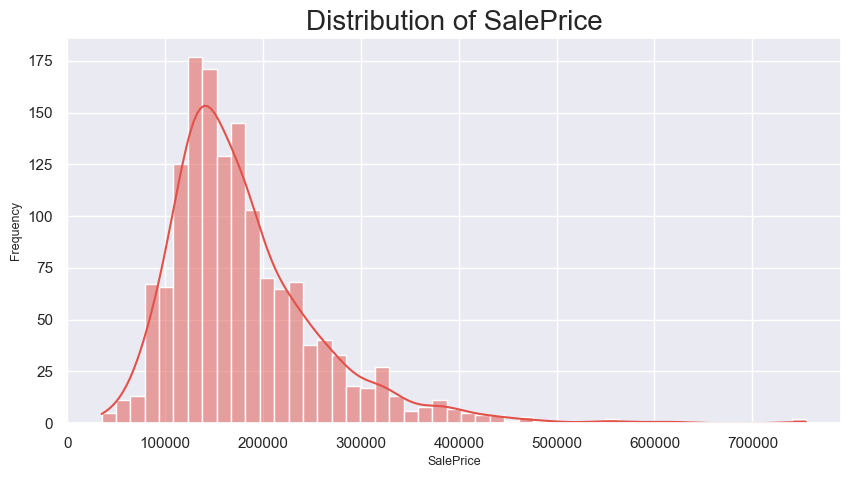

In [241]:
def plot_target_hist(df, target_var):
    """
    Function to plot a histogram of the target variable with KDE overlay.
    """
    plt.figure(figsize=(10, 5))
    sns.histplot(
        data=df,
        x=target_var,
        kde=True,
        color=sns.color_palette("Spectral")[0]
    )
    plt.title(f"Distribution of {target_var}", fontsize=20)
    plt.xlabel(target_var, fontsize=9)
    plt.ylabel("Frequency", fontsize=9)
    plt.savefig(f'docs/plots/hist_plot_{target_var}.png', bbox_inches='tight')        
    plt.show()

# Analyze the distribution of SalePrice
plot_target_hist(df_eda, 'SalePrice')

### 4.3 Bivariate Analysis of Key Variables and SalePrice

To address **Business Requirement 1**, which is to discover how house attributes correlate with the sale price. This involves performing a bivariate analysis to examine the relationship between each variable in `vars_to_study` and the target variable `SalePrice`.

We create three types of visualizations, which help us answer **Business Requirement 1**:
* **Linear regression plots** for continuous variables.
* **Boxplots** for categorical variables.
* **Line plots** for time variables.

The function `create_visualizations` automates the process of visualization by iterating through all variables in `vars_to_study` and selecting the appropriate visualization based on the variable type.

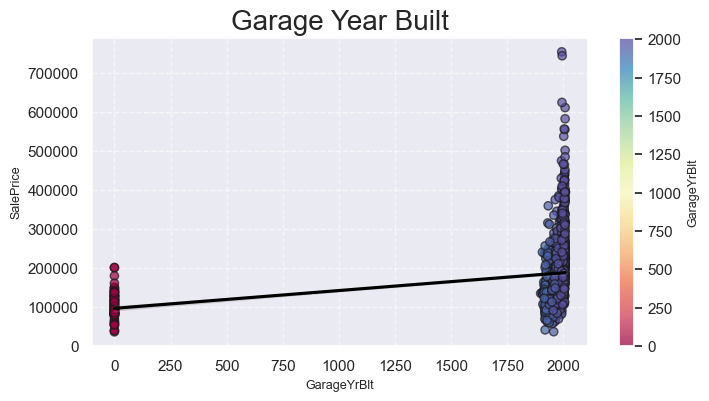

*** Linear regression plot created for variable: GarageYrBlt




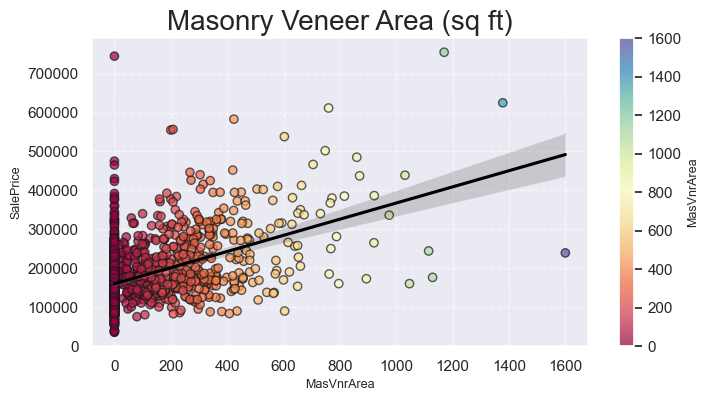

*** Linear regression plot created for variable: MasVnrArea




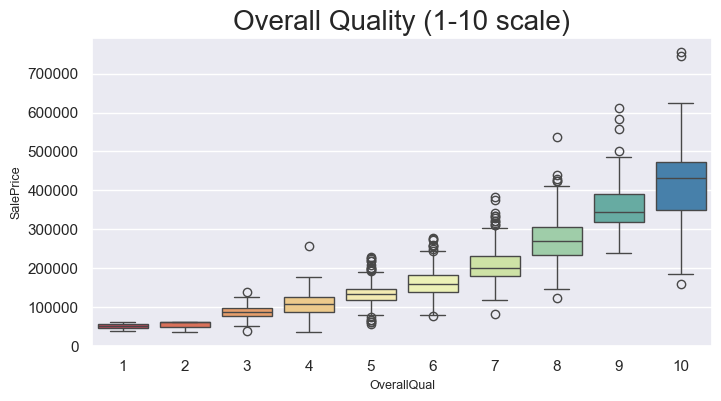

*** Boxplot created for variable: OverallQual




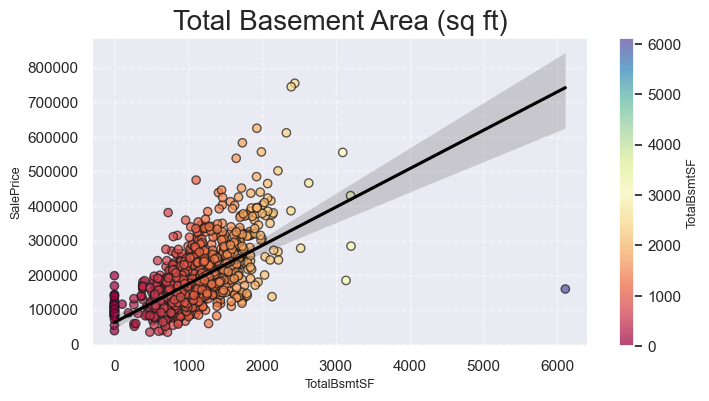

*** Linear regression plot created for variable: TotalBsmtSF




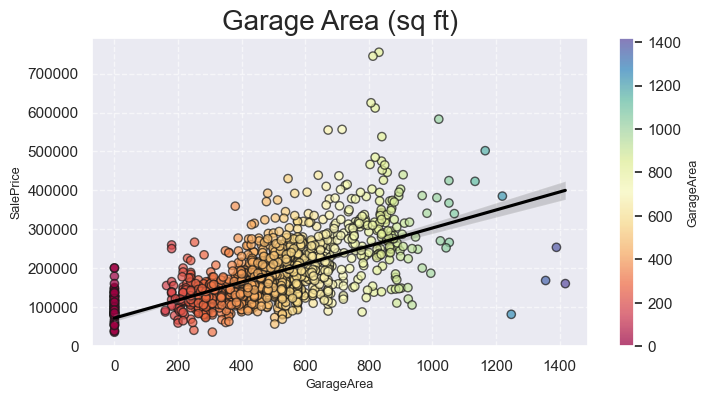

*** Linear regression plot created for variable: GarageArea




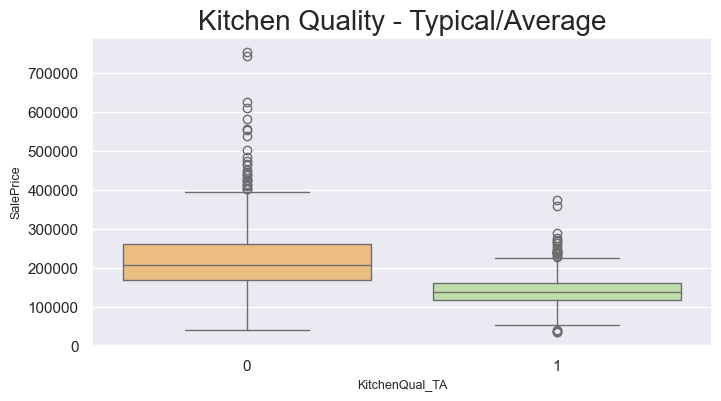

*** Boxplot created for variable: KitchenQual_TA




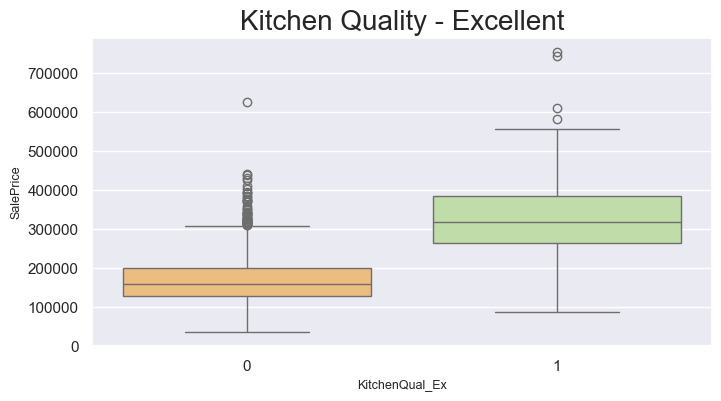

*** Boxplot created for variable: KitchenQual_Ex




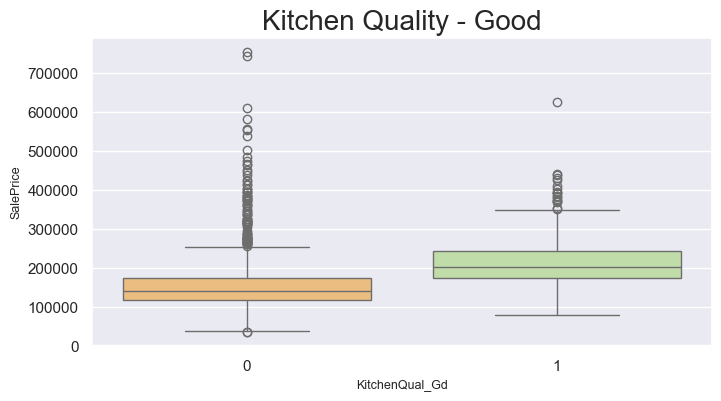

*** Boxplot created for variable: KitchenQual_Gd




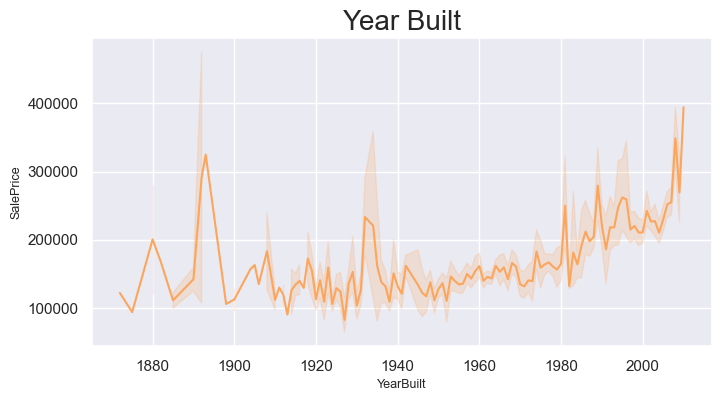

*** Line plot created for variable: YearBuilt




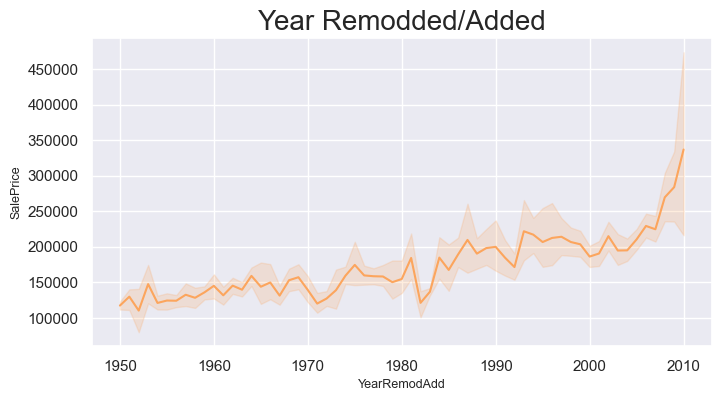

*** Line plot created for variable: YearRemodAdd




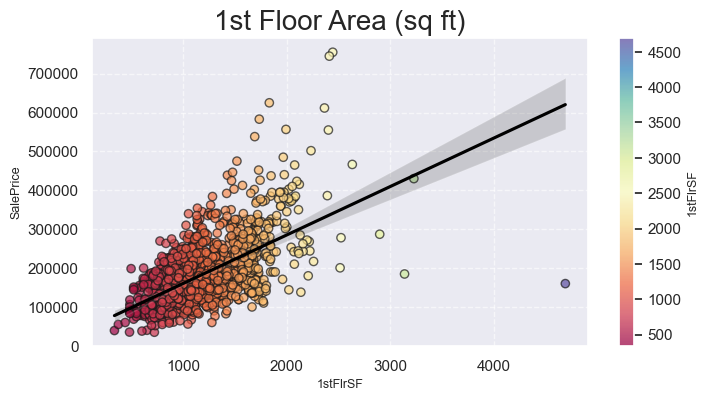

*** Linear regression plot created for variable: 1stFlrSF




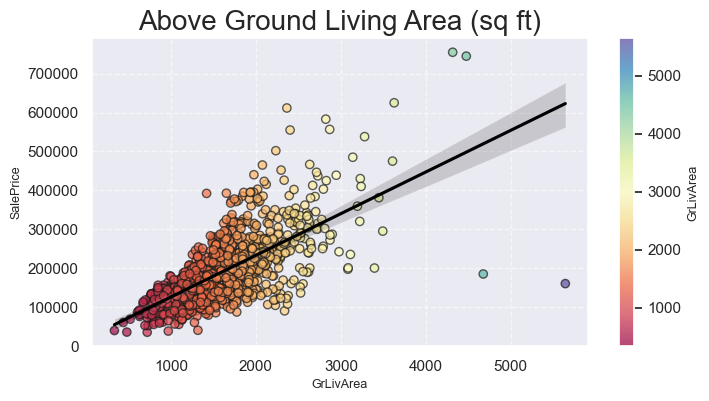

*** Linear regression plot created for variable: GrLivArea




In [242]:
# Set theme
sns.set_style('darkgrid')

# Time variables
time = ['YearBuilt', 'YearRemodAdd']

# Dictionary for variables names
variable_names = {
    'YearBuilt': 'Year Built',
    'YearRemodAdd': 'Year Remodded/Added',
    'GrLivArea': 'Above Ground Living Area (sq ft)',
    'GarageArea': 'Garage Area (sq ft)',
    'OverallQual': 'Overall Quality (1-10 scale)',
    'SalePrice': 'Sale Price (USD)',
    '1stFlrSF': '1st Floor Area (sq ft)',
    'KitchenQual_Gd': 'Kitchen Quality - Good',
    'KitchenQual_Ex': 'Kitchen Quality - Excellent',
    'KitchenQual_TA': 'Kitchen Quality - Typical/Average',
    'TotalBsmtSF': 'Total Basement Area (sq ft)',
    'MasVnrArea': 'Masonry Veneer Area (sq ft)',
    'GarageYrBlt': 'Garage Year Built',
}


# Function to create linear regression plots for continuous variables.
def plot_lm(df, col, target_var):
    plt.figure(figsize=(8, 4))

    # Scatter plot
    scatter = plt.scatter(
        x=df[col], 
        y=df[target_var], 
        c=df[col], 
        cmap='Spectral', 
        alpha=0.7, 
        edgecolor='k'
    )

    # Regression line
    sns.regplot(
        data=df, 
        x=col, 
        y=target_var, 
        scatter=False,
        line_kws={'color': 'black'} 
    )

    # Colors
    cbar = plt.colorbar(scatter)
    cbar.set_label(f"{col}", fontsize=9)

    # Title and labels
    plt.title(f"{variable_names.get(col, col)}", fontsize=20)
    plt.xlabel(col, fontsize=9)
    plt.ylabel(target_var, fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Save plot figure
    plt.savefig(f'docs/plots/lm_plot_price_by_{col}.png', bbox_inches='tight')

    # Show plot
    plt.show()

# Function to create box plots for categorical variables.
def plot_box(df, col, target_var):

    # Count unique categories
    num_categories = len(df[col].unique()) 
    palette = sns.color_palette("Spectral", n_colors=num_categories)

    # Create box plot
    plt.figure(figsize=(8, 4))
    sns.boxplot(
        data=df, 
        x=col, 
        y=target_var, 
        palette=palette
    ) 

    # Title and labels
    plt.title(f"{variable_names.get(col, col)}", fontsize=20)
    plt.xlabel(col, fontsize=9)
    plt.ylabel(target_var, fontsize=9)

    # Save plot figure
    plt.savefig(f'docs/plots/box_plot_price_by_{col}.png', bbox_inches='tight')

    # Show plot
    plt.show()

# Function to create line plots for time variables.
def plot_line(df, col, target_var):

    # Create line plot
    plt.figure(figsize=(8, 4))
    sns.lineplot(
        data=df, 
        x=col, 
        y=target_var, 
        color=sns.color_palette("Spectral")[1]
    )

    # Title and labels
    plt.title(f"{variable_names.get(col, col)}", fontsize=20)
    plt.xlabel(col, fontsize=9)
    plt.ylabel(target_var, fontsize=9)

    # Save plot figure
    plt.savefig(f'docs/plots/line_plot_price_by_{col}.png', bbox_inches='tight') 

    # Show plot
    plt.show()

# Loop for appropriate visualizations based on variable types
def create_visualizations(df, vars_to_study, target_var):
    
    # Loop through variables
    for col in vars_to_study:

        # Check if the variable is categorical, time, or continuous
        if len(df[col].unique()) <= 10:
            plot_box(df, col, target_var)
            print(f"*** Boxplot created for variable: {col}\n\n")

        elif col in time:  # Time variables
            plot_line(df, col, target_var)
            print(f"*** Line plot created for variable: {col}\n\n")

        else:  # Continuous variables
            plot_lm(df, col, target_var)
            print(f"*** Linear regression plot created for variable: {col}\n\n")

# Call the function to create visualizations
create_visualizations(df_eda, vars_to_study, 'SalePrice')

## Conclusions and Next Steps

### Conclusions
The correlation analysis and visualization process was successfully completed, providing valuable insights into the relationships between house attributes and sale prices. These findings will guide the next steps in feature engineering and modeling.

#### Key Observations:
1. **Size Matters**: Larger properties, as indicated by variables like `1stFlrSF`, `GrLivArea`, `TotalBsmtSF`, and `GarageArea`, are strongly associated with higher sale prices.
2. **Time Matters**: Recently built houses (`YearBuilt`) and houses with recent remodels (`YearRemodAdd`) tend to have higher sale prices, reflecting the value of modern features and updates.
3. **Quality Matters**: Higher overall quality (`OverallQual`) and kitchen quality (`KitchenQual`) ratings are among the strongest predictors of higher sale prices.

All visualizations were saved in the `docs/plots` directory for further use in the Streamlit app and to meet **Business Requirement 1**.

### Next Steps: Feature Engineering
1. **Handle Outliers**: Investigate and address outliers in key variables like `GrLivArea`, `TotalBsmtSF`, and `GarageArea` to improve model robustness.
2. **Transform Variables**: Apply log transformations to `SalePrice` and other skewed variables to enhance linearity and meet modeling assumptions.
3. **Create New Features**: Combine existing variables to create new features that capture additional information, such as total square footage or age of the property.
4. **Scale Data**: Standardize or normalize numerical variables to ensure consistent scaling across features for machine learning models.
5. **Incorporate Insights**: Leverage the findings from the correlation analysis to prioritize and engineer features that are most predictive of `SalePrice`.